d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
d:\Conda\envs\RL_Simple\lib\site-packages\gym\wrappers\step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is rec

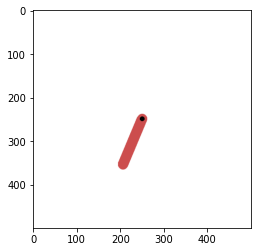

In [2]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('Pendulum-v1')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [3]:
#测试游戏环境
def test_env():
    state = env.reset()
    print('这个游戏的状态用3个数字表示,我也不知道这3个数字分别是什么意思,反正这3个数字就能描述游戏全部的状态')
    print('state=', state)
    #state= [-0.91304934 -0.40784913  0.271098  ]

    print('这个游戏的动作是个-2到+2之间的连续值')
    print('env.action_space=', env.action_space)
    #env.action_space= Box(-2.0, 2.0, (1,), float32)

    print('随机一个动作')
    action = env.action_space.sample()
    print('action=', action)
    #action= [-0.14946985]

    print('执行一个动作,得到下一个状态,奖励,是否结束')
    state, reward, over, _ = env.step(action)

    print('state=', state)
    #state= [-0.5629868  0.8264659  2.7232552]

    print('reward=', reward)
    #reward= -4.456876123969679

    print('over=', over)
    #over= False


test_env()

这个游戏的状态用3个数字表示,我也不知道这3个数字分别是什么意思,反正这3个数字就能描述游戏全部的状态
state= [ 0.03546621 -0.9993709  -0.8007599 ]
这个游戏的动作是个-2到+2之间的连续值
env.action_space= Box(-2.0, 2.0, (1,), float32)
随机一个动作
action= [-1.7534152]
执行一个动作,得到下一个状态,奖励,是否结束
state= [-0.05516336 -0.99847734 -1.8133004 ]
reward= -2.4244118490790796
over= False


In [5]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [6]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

(7, 0.7999999999999998)

In [7]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas),datas

((200, 0),
 200,
 [(array([ 0.66784006, -0.7443048 ,  0.08031203], dtype=float32),
   8,
   -0.7068339425778133,
   array([ 0.65667933, -0.7541699 , -0.29791656], dtype=float32),
   False),
  (array([ 0.65667933, -0.7541699 , -0.29791656], dtype=float32),
   8,
   -0.7402961499725329,
   array([ 0.63052547, -0.7761686 , -0.683544  ], dtype=float32),
   False),
  (array([ 0.63052547, -0.7761686 , -0.683544  ], dtype=float32),
   9,
   -0.8388332933329097,
   array([ 0.5899093, -0.8074695, -1.0256704], dtype=float32),
   False),
  (array([ 0.5899093, -0.8074695, -1.0256704], dtype=float32),
   9,
   -0.9910776470107872,
   array([ 0.53235734, -0.8465197 , -1.3912725 ], dtype=float32),
   False),
  (array([ 0.53235734, -0.8465197 , -1.3912725 ], dtype=float32),
   9,
   -1.215039418265126,
   array([ 0.4547351, -0.8906267, -1.7861624], dtype=float32),
   False),
  (array([ 0.4547351, -0.8906267, -1.7861624], dtype=float32),
   9,
   -1.5287866459438062,
   array([ 0.35355434, -0.93541396,

In [9]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

d:\Conda\envs\RL_Simple\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  import sys


(tensor([[-9.8139e-01,  1.9201e-01, -1.9118e-01],
         [-9.0208e-01, -4.3157e-01,  4.7579e+00],
         [ 4.5474e-01, -8.9063e-01, -1.7862e+00],
         [-9.5385e-01,  3.0027e-01, -3.6489e-01],
         [-9.9764e-01,  6.8634e-02, -9.5601e-02],
         [-9.7791e-01,  2.0902e-01, -3.4717e-01],
         [-7.4540e-01, -6.6661e-01,  5.0698e-01],
         [-9.6721e-01,  2.5399e-01, -1.5984e+00],
         [-9.9614e-01,  8.7770e-02, -3.9785e-02],
         [-7.1426e-01,  6.9988e-01, -4.1087e+00],
         [-9.9938e-01, -3.5089e-02, -2.4828e+00],
         [-8.6557e-01, -5.0078e-01, -1.2133e+00],
         [-2.2176e-02, -9.9975e-01,  2.8587e-01],
         [-1.4064e-01, -9.9006e-01, -1.3013e+00],
         [-8.6396e-01, -5.0357e-01,  1.5520e+00],
         [-7.8773e-01, -6.1602e-01,  1.0946e+00],
         [-9.8740e-01,  1.5823e-01,  1.4297e+00],
         [-2.2925e-01, -9.7337e-01, -1.8038e+00],
         [-9.6593e-01,  2.5882e-01,  1.3814e-01],
         [-8.7311e-01,  4.8752e-01, -2.7009e+00],


In [10]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[ 0.2942],
        [ 1.0706],
        [ 0.7156],
        [ 0.3311],
        [ 0.2652],
        [ 0.3440],
        [ 0.3115],
        [ 0.8043],
        [ 0.2569],
        [ 1.6179],
        [ 1.1282],
        [ 0.7486],
        [ 0.3933],
        [ 0.6670],
        [ 0.5026],
        [ 0.4545],
        [ 0.4008],
        [ 0.8621],
        [ 0.2531],
        [ 1.1617],
        [ 0.5061],
        [ 0.3875],
        [ 0.2886],
        [ 0.8180],
        [ 0.7611],
        [ 0.4564],
        [ 0.4263],
        [ 0.5957],
        [ 0.5244],
        [ 0.2733],
        [ 0.8399],
        [ 0.5042],
        [ 0.3424],
        [ 1.3662],
        [ 0.2875],
        [ 0.5560],
        [ 0.2666],
        [-0.2140],
        [ 0.9263],
        [ 0.5447],
        [ 0.3850],
        [ 0.5885],
        [ 1.8510],
        [ 1.2043],
        [ 0.2930],
        [ 0.2452],
        [ 0.9375],
        [ 0.2869],
        [ 0.3083],
        [ 1.0421],
        [ 0.2822],
        [ 0.4611],
        [ 0.

In [11]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)

    #取所有动作中分数最大的
    #[b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[-8.3635],
        [-8.5175],
        [-0.7002],
        [-7.8054],
        [-9.0897],
        [-8.3532],
        [-5.5898],
        [-7.9501],
        [-9.0044],
        [-5.9701],
        [-9.2481],
        [-6.2250],
        [-2.2793],
        [-2.2576],
        [-6.5987],
        [-5.8816],
        [-8.6691],
        [-2.5573],
        [-8.0379],
        [-6.7426],
        [-6.9942],
        [-5.7026],
        [-5.5895],
        [-6.9975],
        [-6.2551],
        [-5.9426],
        [-8.5712],
        [-9.4564],
        [-5.4908],
        [-2.1240],
        [-4.4468],
        [-6.5238],
        [-8.8889],
        [-4.4467],
        [-8.9740],
        [-3.9217],
        [-8.0299],
        [-7.1921],
        [-4.7775],
        [-4.2813],
        [-8.0513],
        [-9.3904],
        [-7.2906],
        [-7.6682],
        [-7.7403],
        [-8.9769],
        [-6.1453],
        [-3.9121],
        [-5.3936],
        [-8.9845],
        [-0.4049],
        [-0.4185],
        [-7.

In [12]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1623.437256060043

In [13]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_count, drop_count = update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum([test(play=False) for _ in range(20)]) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -1246.8968669772246
20 4400 200 0 -595.126081039655
40 5000 200 200 -694.60943608486
60 5000 200 200 -229.6561511168107
80 5000 200 200 -353.7412615514566
100 5000 200 200 -172.69374653462756
120 5000 200 200 -180.6643132624166
140 5000 200 200 -144.64553378568263
160 5000 200 200 -178.12928164822677
180 5000 200 200 -304.2143192798874


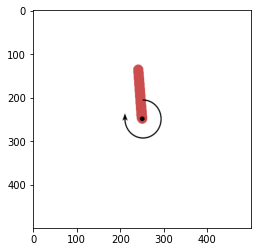

-123.68684372041675

In [15]:
test(play=True)